<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/W207_Breast_Cancer_IDC_Classification_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
**Heesuk Jang**

In [2]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import cv2 as cv
import skimage.io as io

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [3]:
%pwd

'/content'

# Load data as a zip file directly from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images) to Colab

In [14]:
# !kaggle datasets download -d paultimothymooney/breast-histopathology-images

# Unzip the downloaded zip and remove the original zip file

In [13]:
# !unzip \*.zip && rm *.zip

In [12]:
%ls

10253/  10305/  12881/  13018/  14153/  16085/  8980/  9255/
10254/  10306/  12882/  13019/  14154/  16165/  8984/  9256/
10255/  10307/  12883/  13020/  14155/  16166/  9022/  9257/
10256/  10308/  12884/  13021/  14156/  16167/  9023/  9258/
10257/  12241/  12886/  13022/  14157/  16531/  9029/  9259/
10258/  12242/  12890/  13023/  14188/  16532/  9035/  9260/
10259/  12626/  12891/  13024/  14189/  16533/  9036/  9261/
10260/  12748/  12892/  13025/  14190/  16534/  9037/  9262/
10261/  12749/  12893/  13106/  14191/  16550/  9041/  9265/
10262/  12750/  12894/  13400/  14192/  16551/  9043/  9266/
10264/  12751/  12895/  13401/  14209/  16552/  9044/  9267/
10268/  12752/  12896/  13402/  14210/  16553/  9073/  9290/
10269/  12810/  12897/  13403/  14211/  16554/  9075/  9291/
10272/  12811/  12898/  13404/  14212/  16555/  9076/  9319/
10273/  12817/  12900/  13458/  14213/  16568/  9077/  9320/
10274/  12818/  12901/  13459/  14304/  16569/  9078/  9321/
10275/  12819/  12905/  

# Read image files from **IDC_regular_ps50_idx5**

In [56]:
def read_image_files(binary_class):
  current_working_dir = os.getcwd()
  folder = 'IDC_regular_ps50_idx5/*/'

  image_files_w_path, image_files_wo_path = [], []
  for img in glob.glob(os.path.join(current_working_dir, folder + binary_class + '/') + '*.png'):
    image_files_w_path.append(img)
    image_wo_path = os.path.basename(img)
    image_files_wo_path.append(image_wo_path)    
  return image_files_wo_path, image_files_w_path

class_1_malignant_wo_path, class_1_malignant_w_path = read_image_files('1')
class_0_benign_wo_path, class_0_benign_w_path = read_image_files('0')
full_data_wo_path = class_1_malignant_wo_path + class_0_benign_wo_path
full_data_w_path = class_1_malignant_w_path + class_0_benign_w_path

print(class_1_malignant_w_path[:2])
print(class_1_malignant_wo_path[:2])
print(full_data_wo_path[0], ',', full_data_wo_path[-1])

['/content/IDC_regular_ps50_idx5/9346/1/9346_idx5_x2051_y2251_class1.png', '/content/IDC_regular_ps50_idx5/9346/1/9346_idx5_x1701_y1701_class1.png']
['9346_idx5_x2051_y2251_class1.png', '9346_idx5_x1701_y1701_class1.png']
9346_idx5_x2051_y2251_class1.png , 13400_idx5_x1651_y2201_class0.png


In [ ]:
# def read_image_files(binary_class):
#   current_working_dir = os.getcwd()
#   folder = 'IDC_regular_ps50_idx5/*/'

#   image_files = []
#   for img in glob.glob(os.path.join(current_working_dir, folder + binary_class + '/') + '*.png'):
#     image_files.append(img)
#   return image_files

# class_1_malignant = read_image_files('1')
# class_0_benign = read_image_files('0')
# full_data = class_1_malignant + class_0_benign

In [48]:
print('class_1:\n',class_1_malignant[:2])
print('\nclass_1 and class_0 combined:\n', full_data[0], '\n', full_data[-1])

class_1:
 ['9346_idx5_x2051_y2251_class1.png', '9346_idx5_x1701_y1701_class1.png']

class_1 and class_0 combined:
 9346_idx5_x2051_y2251_class1.png 
 13400_idx5_x1651_y2201_class0.png


# Check the number of image files in each class


In [49]:
def check_class_size(class_1, class_0):
  class_1_size, class_0_size = len(class_1), len(class_0)
  count = pd.Series([class_1_size, class_0_size])
  percent = round(count/(class_1_size + class_0_size)*100, 2)
  df_perc = pd.concat({'class_count':count, 'class_percent(%)':percent}, axis=1)
  df_perc['class'] = ['Class 1 (Malignant)', 'Class 0 (Benign)']
  df_perc = df_perc[['class','class_count','class_percent(%)']]
  print('Total Count = ', class_1_size + class_0_size)
  return df_perc

check_class_size(class_1_malignant, class_0_benign)

Total Count =  277524


,class,class_count,class_percent(%)
0,Class 1 (Malignant),78786,28.39
1,Class 0 (Benign),198738,71.61


# Display the first 5 images for each class
: 50 by 50 pixels per image

FileNotFoundError: ignored

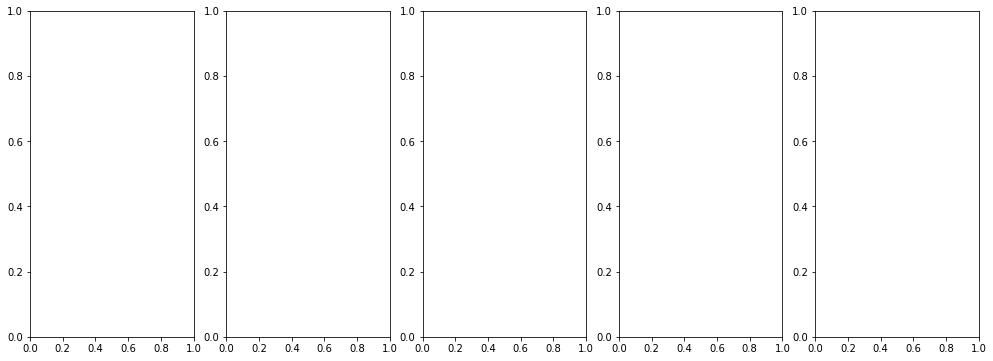

In [50]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(17,6))
  for idx in range(len(subclass[:5])):
    mal_img = io.imread(subclass[idx])
    # print(mal_img.means())
    axes[idx].imshow(mal_img)
    axes[idx].set_title(class_name)
  plt.show() 

display_images(class_1_malignant, 'Class 1')
display_images(class_0_benign, 'Class 0')

# Extract image patch coordinate (x, y) from file names

In [46]:
print(os.path.basename('/content/IDC_regular_ps50_idx5/9346/1/9346_idx5_x2051_y2251_class1.png'))

9346_idx5_x2051_y2251_class1.png


In [20]:
import re
import os

print

In [44]:
s = '9346_idx5_x2051_y2251_class1.png'
m = re.search(r'\d+', s)
print(m.group())

f = re.findall(r'\d+', s)
conv = [int(i) for i in f]
print(conv)

9346
[9346, 5, 2051, 2251, 1]
